In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital1 import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = False
model_name = 'test_succ_inc3'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col = 'description_succ_inc',#'ts_description',
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    txt2ts_y_cols = ['description_succ_inc'],
    custom_target_cols = ['description_succ_inc', 'label'], # 'label' is the same as the default "by_label" target
    # downsample = True,
    # downsample_size = 30000,
    model_name = model_name,
    embedded_dim = 256,
    batch_size = 512, # Data loader settings
    patience = 100, # Training settings
    num_saves = 10,
    num_epochs = 10,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': False}  # Add this line
)
config_dict = get_config_dict()


#  result saving directory
output_dir = './results/'+config_dict['model_name']
model_clip_path = output_dir+'/model_clip.pth' 
eval_clip_path = output_dir+'/evals_clip.pth'
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.1s
[Parallel(n_jobs=9)]: Done 3739 tasks      | elapsed:    4.7s
[Parallel(n_jobs=9)]: Done 63343 tasks      | elapsed:   12.5s
[Parallel(n_jobs=9)]: Done 65100 out of 65100 | elapsed:   12.8s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    42910
Low amount of consecutive increases.         11838
High amount of consecutive increases.        10352
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.1s
[Parallel(n_jobs=9)]: Done 60894 tasks      | elapsed:    7.9s
[Parallel(n_jobs=9)]: Done 61197 out of 61197 | elapsed:    7.9s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    36173
Low amount of consecutive increases.         13165
High amount of consecutive increases.        11859
Name: count, dtype: int64
After downsampling:
description_succ_inc
Low amount of consecutive increases.     11838
High amount of consecutive increases.    10352
Name: count, dtype: int64
After downsampling:
description_succ_inc
Low amount of consecutive increases.     6582
High amount of consecutive increases.    5930
Name: count, dtype: int64


final distribution of text prediction
description_succ_inc
Low amount of consecutive increases.     11838
High amount of consecutive increases.    10352
Name: count, dtype: int64
description_succ_inc
Low amount of consecutive increases.     6582
High amount of consecutive increases.    5930
Name: count, dtype: int64


### Customize VITAL Model

In [5]:
# overwrite = False
# customize model
if overwrite or not os.path.exists(model_path):    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    

    
    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path, map_location=torch.device(device))
    model = config_dict['model_init']
    print(nn_summary(model))
    model.device = device

    

Layer (type:depth-idx)                                            Param #
VITAL                                                             1
├─TSVAEEncoder: 1-1                                               --
│    └─LocalNorm: 2-1                                             --
│    └─Sequential: 2-2                                            --
│    │    └─MultiLSTMEncoder: 3-1                                 11,111,424
│    │    └─LayerNorm: 3-2                                        512
│    │    └─Linear: 3-3                                           131,584
│    │    └─LeakyReLU: 3-4                                        --
│    │    └─LayerNorm: 3-5                                        1,024
│    │    └─Linear: 3-6                                           131,328
│    │    └─LeakyReLU: 3-7                                        --
│    │    └─LayerNorm: 3-8                                        512
│    └─Linear: 2-3                                                65,792
│  

### Train ts_mu

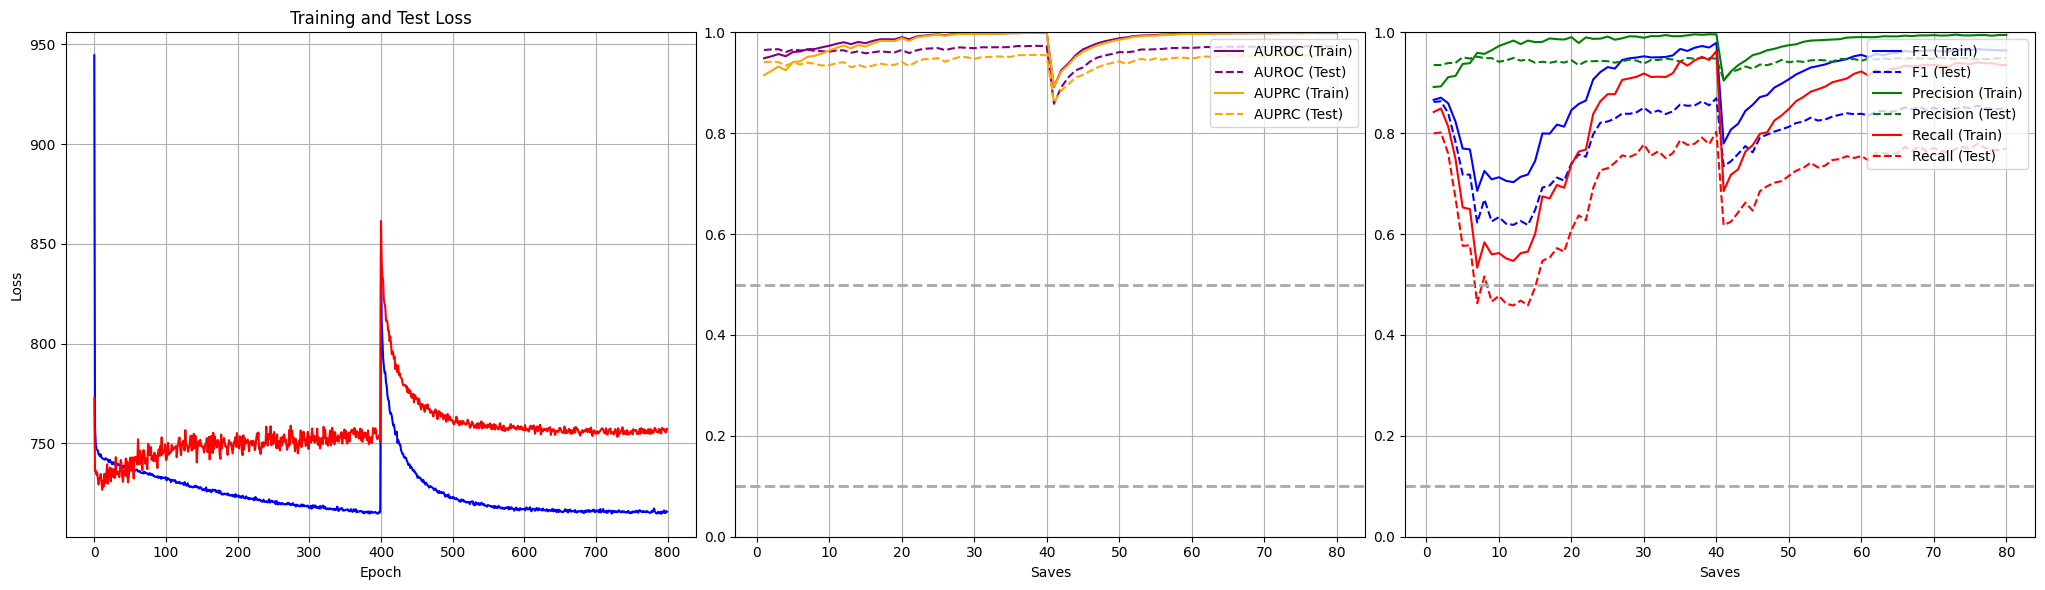

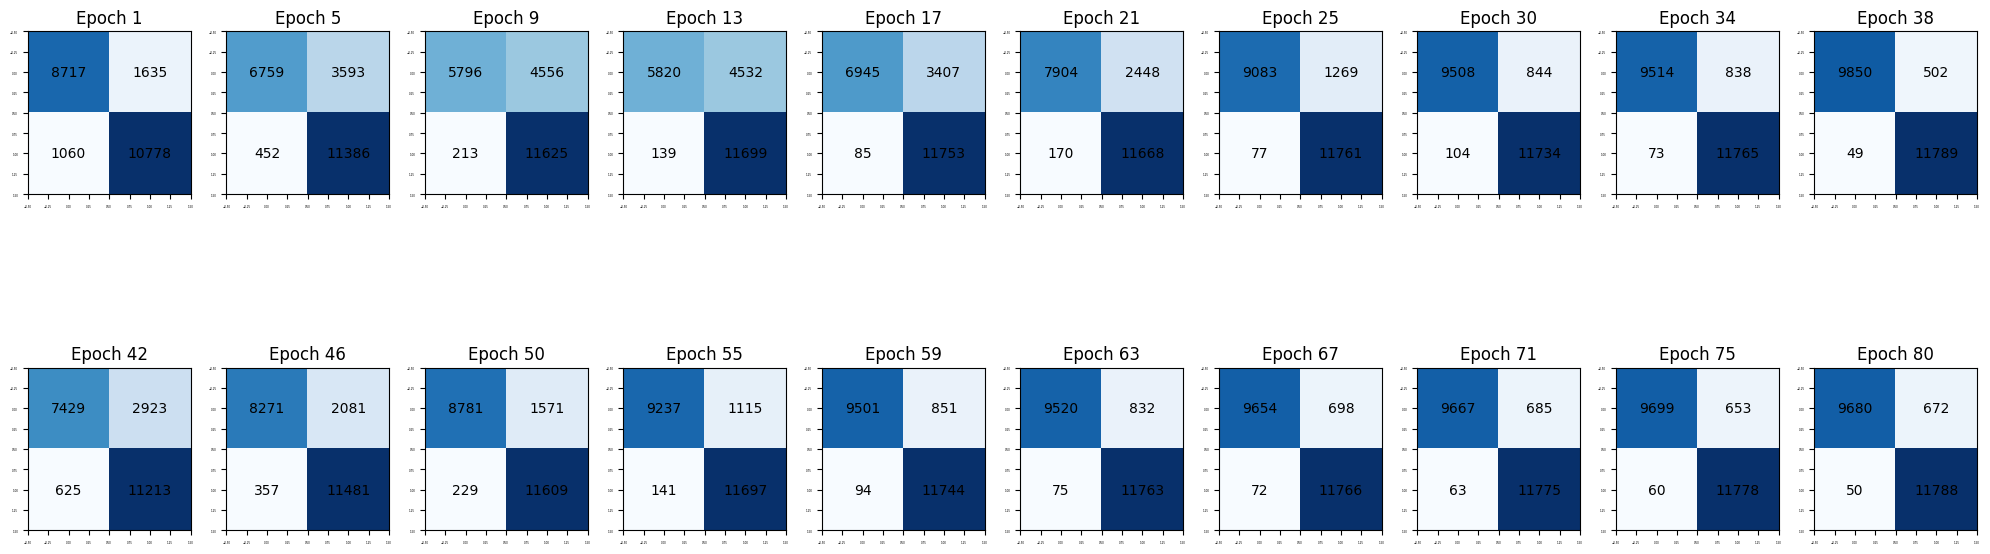

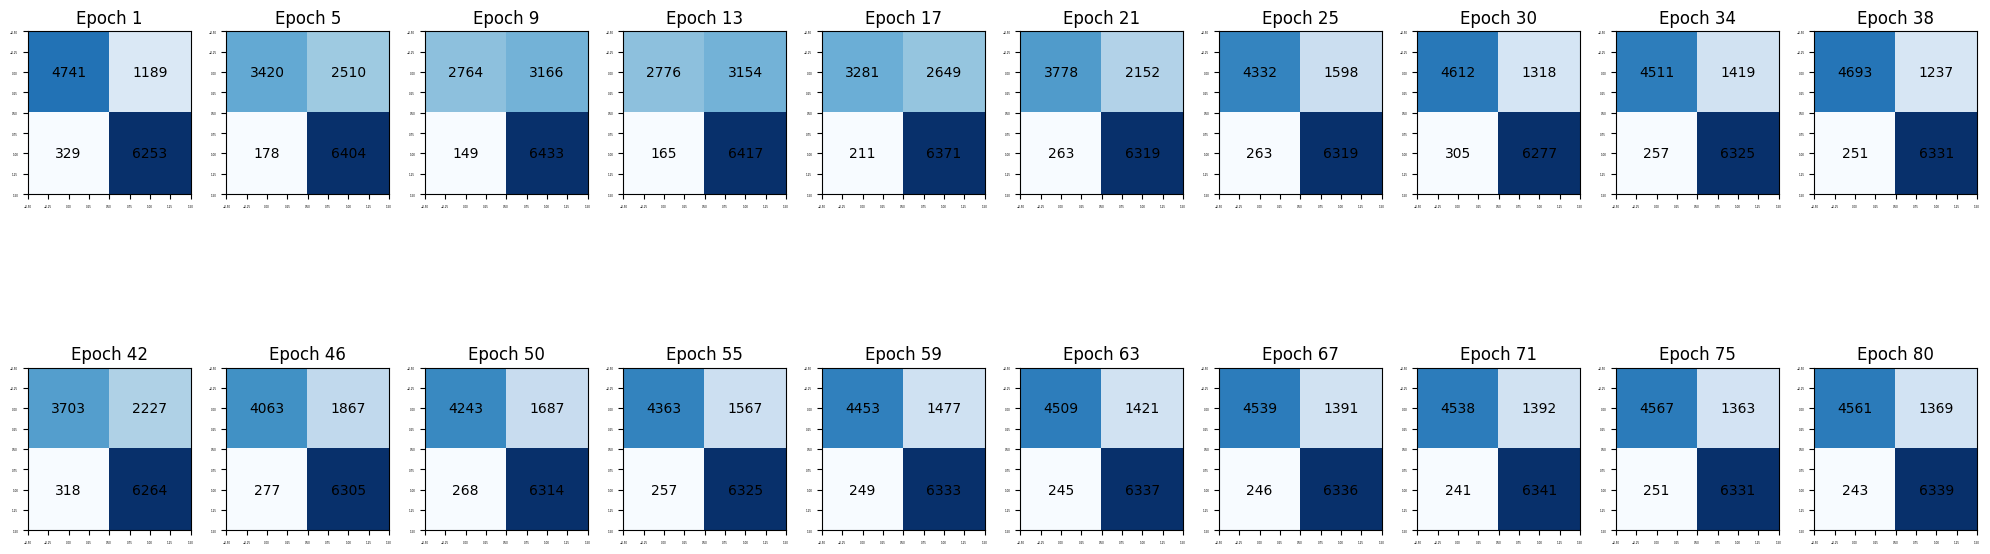

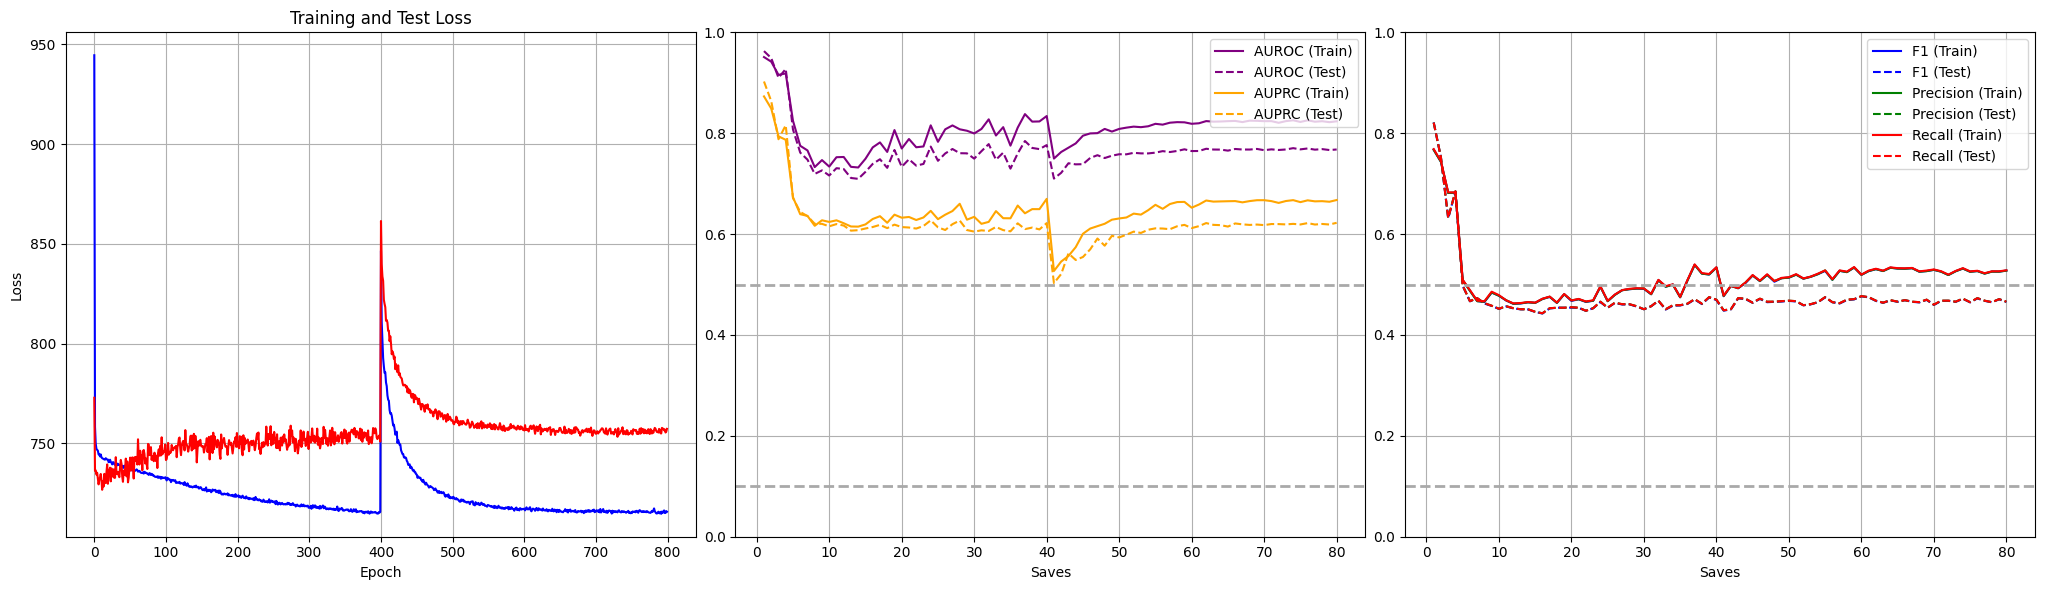

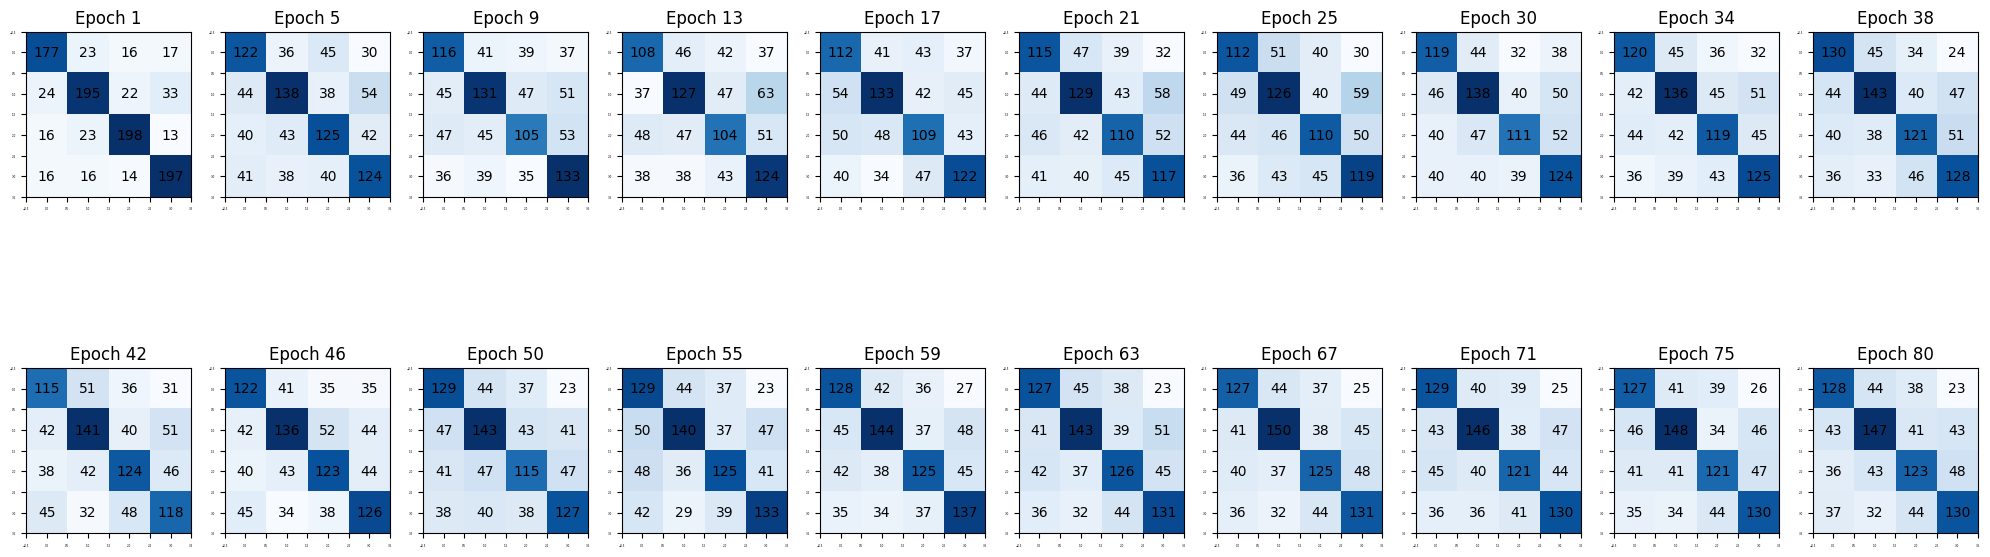

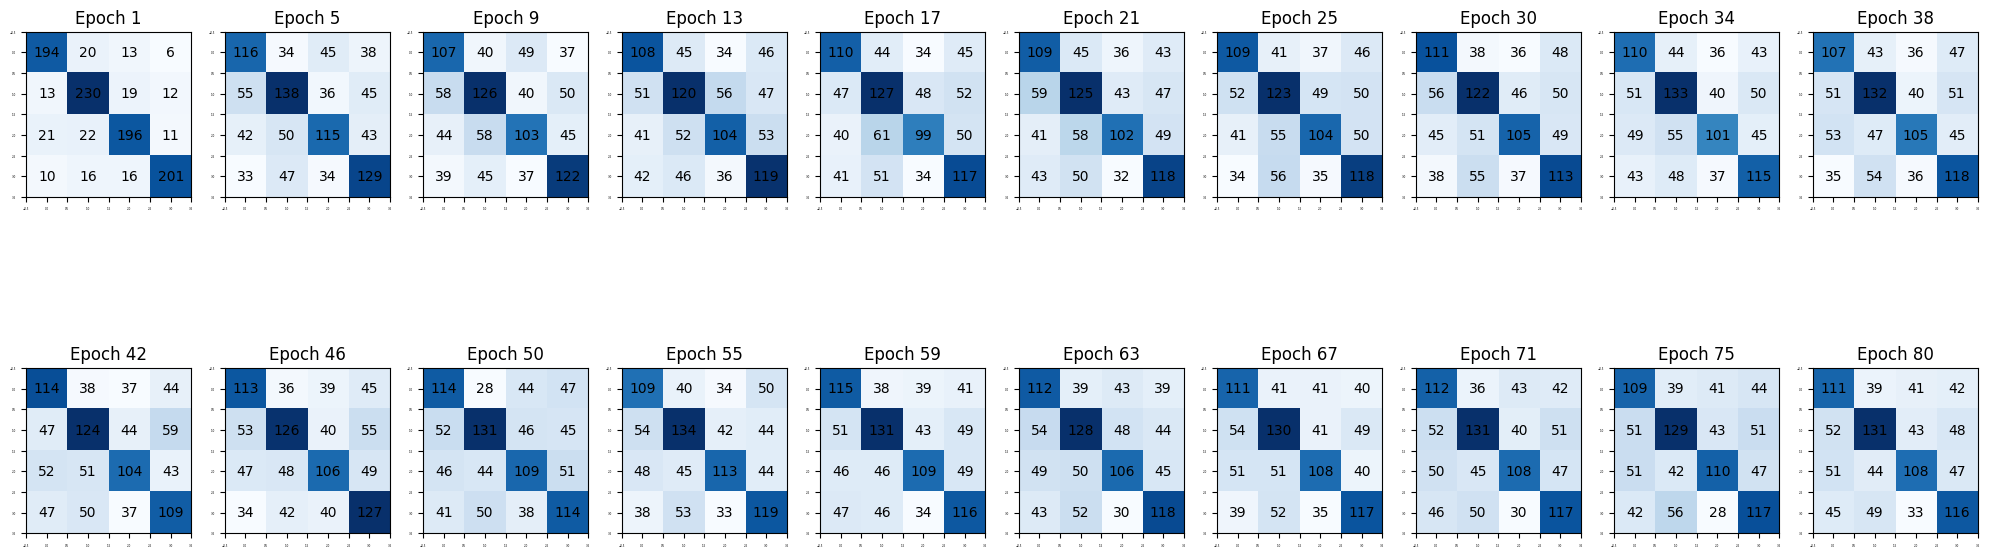

In [6]:
# overwrite = False
if overwrite or not os.path.exists(model_clip_path):

    # ------------------------- ready training for clip -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=100,      
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more

    
    for i in range(60):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        target_type = 'by_target',
                                                        train_type='clip',
                                                        alpha = 1/1000)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_clip_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')
    
        # print results 
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
else:
    model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
    model.eval()
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    
    

### train ts_var

In [7]:
# overwrite = False
if overwrite:
    
    model.clip_mu = False
    # ------------------------- ready training for vae decoder -------------------------
    # 1. Freeze encoders
    for param in model.ts_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False
    # 2. Unfreeze logvar_layer in ts_encoder to trainable
    for param in model.ts_encoder.logvar_layer.parameters():
        param.requires_grad = True
    # 3. Unfreeze decoder
    for param in model.ts_decoder.parameters():
        param.requires_grad = False
    # Verify parameters
    print("Checking trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}")

    # Create optimizer with only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=50,       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-3,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more




    for i in range(40):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        target_type = 'by_target',
                                                        train_type='clip')
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_clip_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')

        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    

### Continue train vae decoder

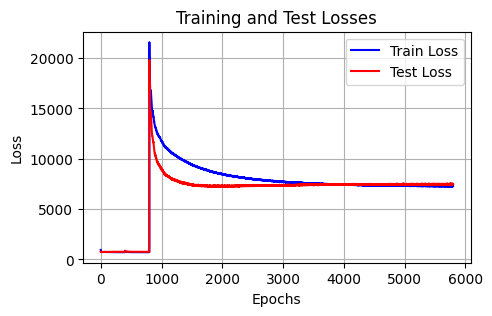

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


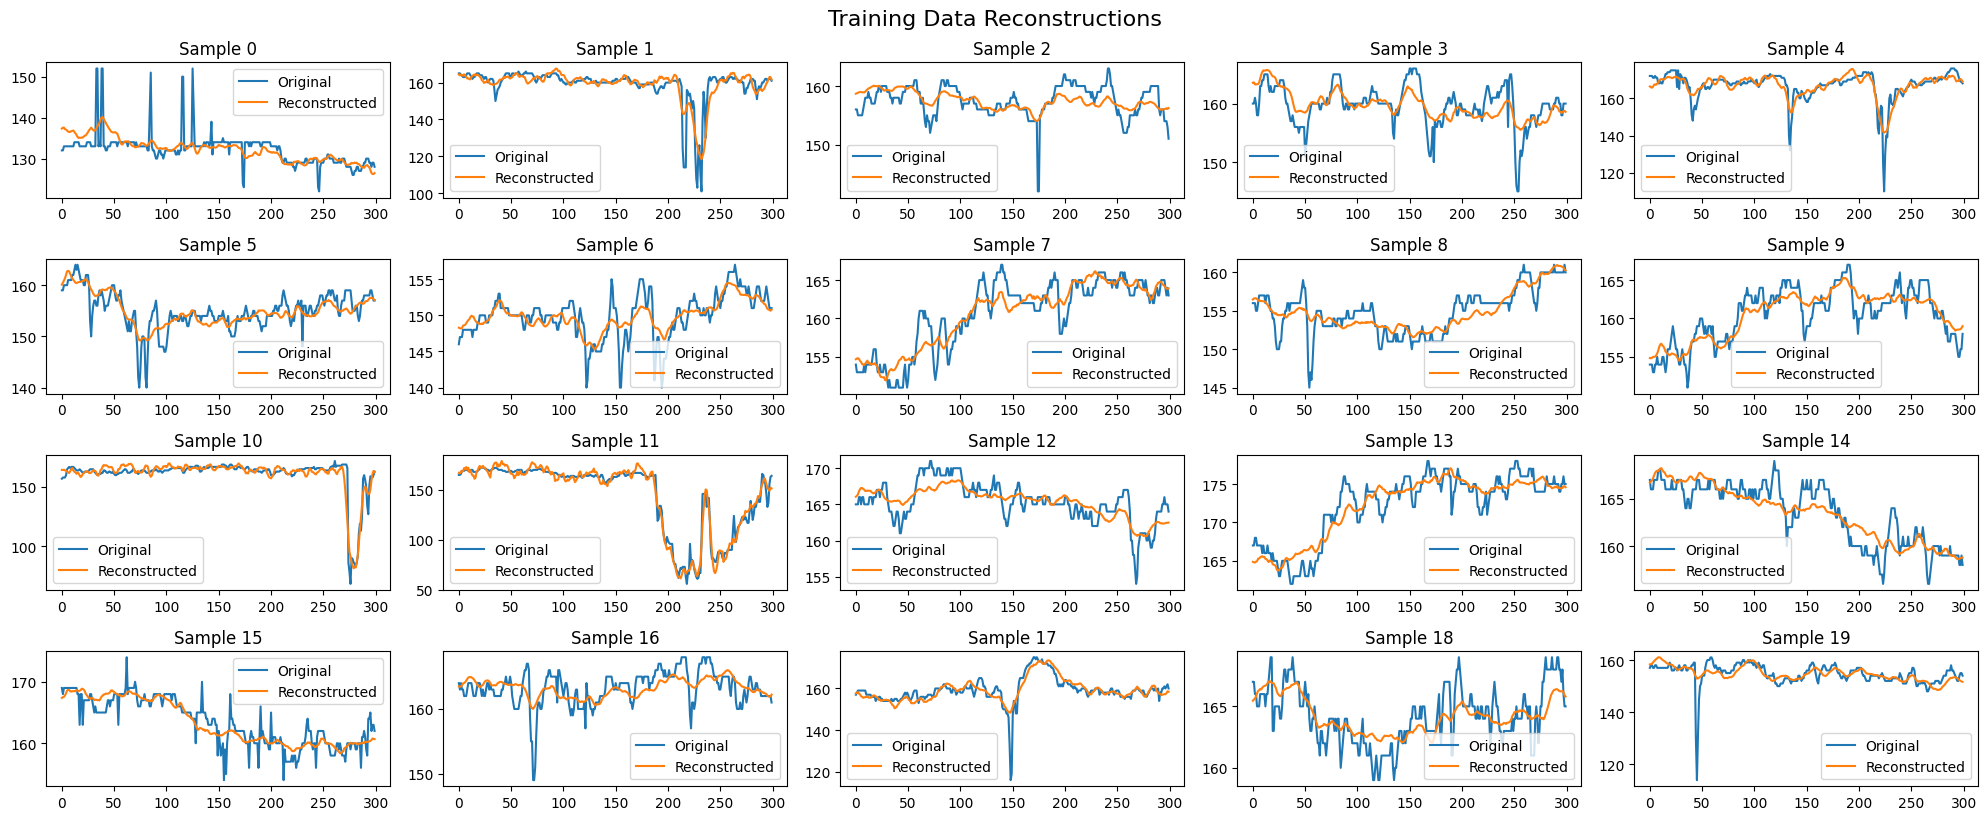

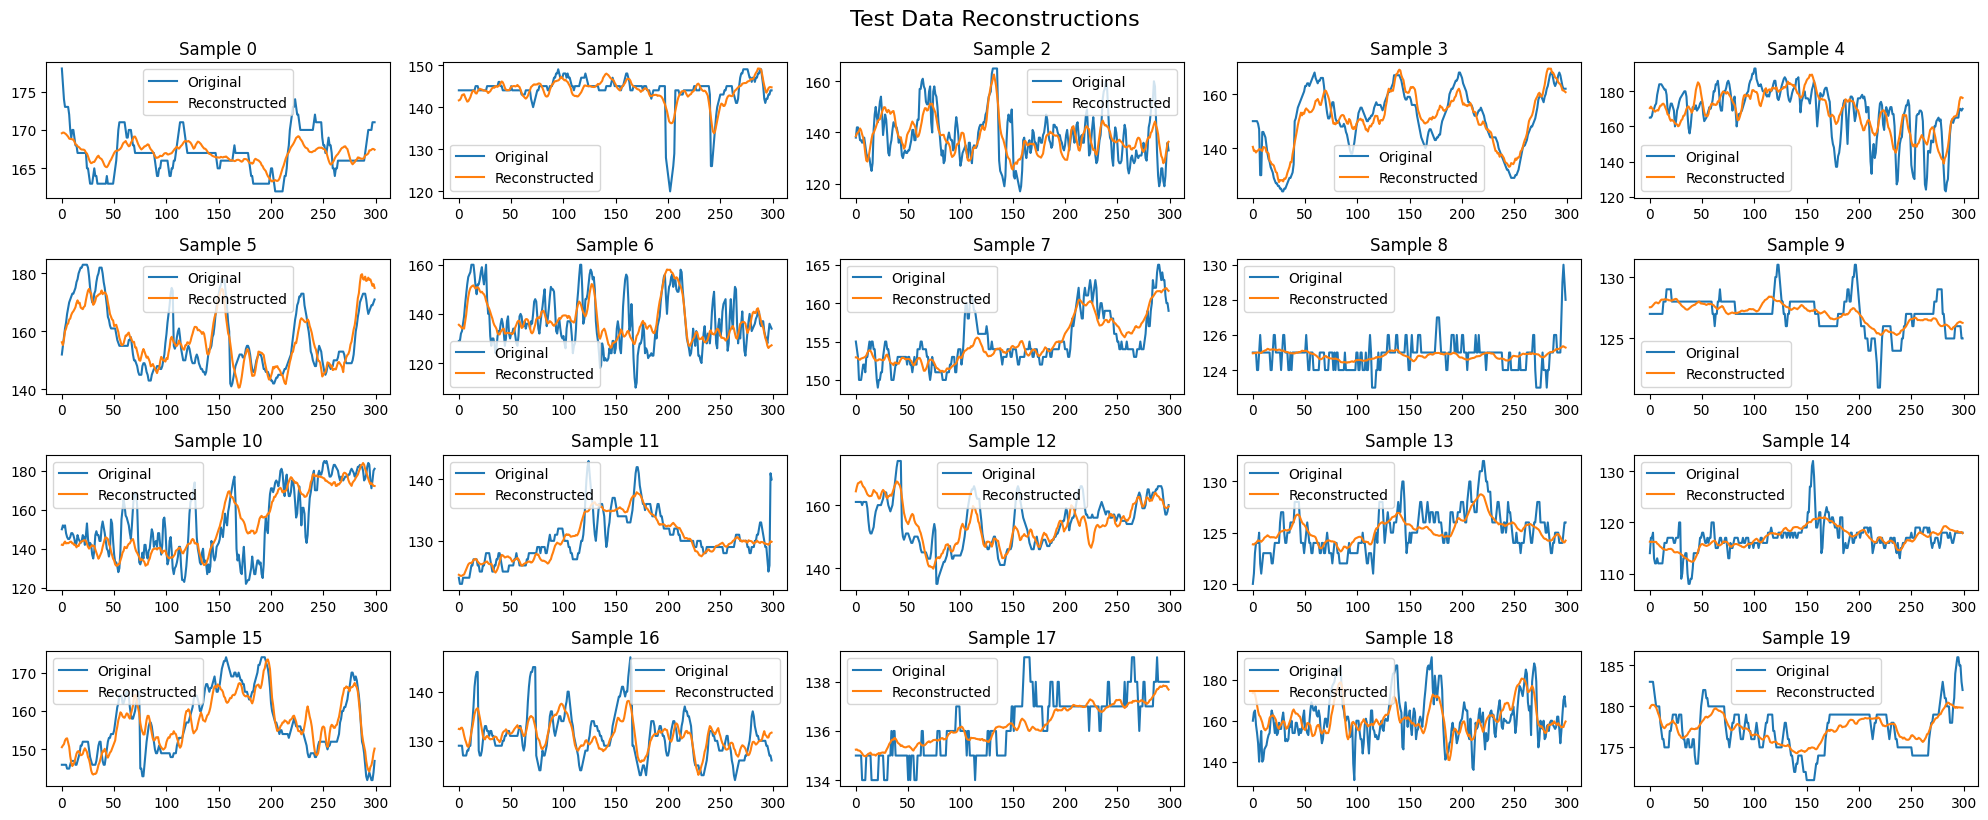

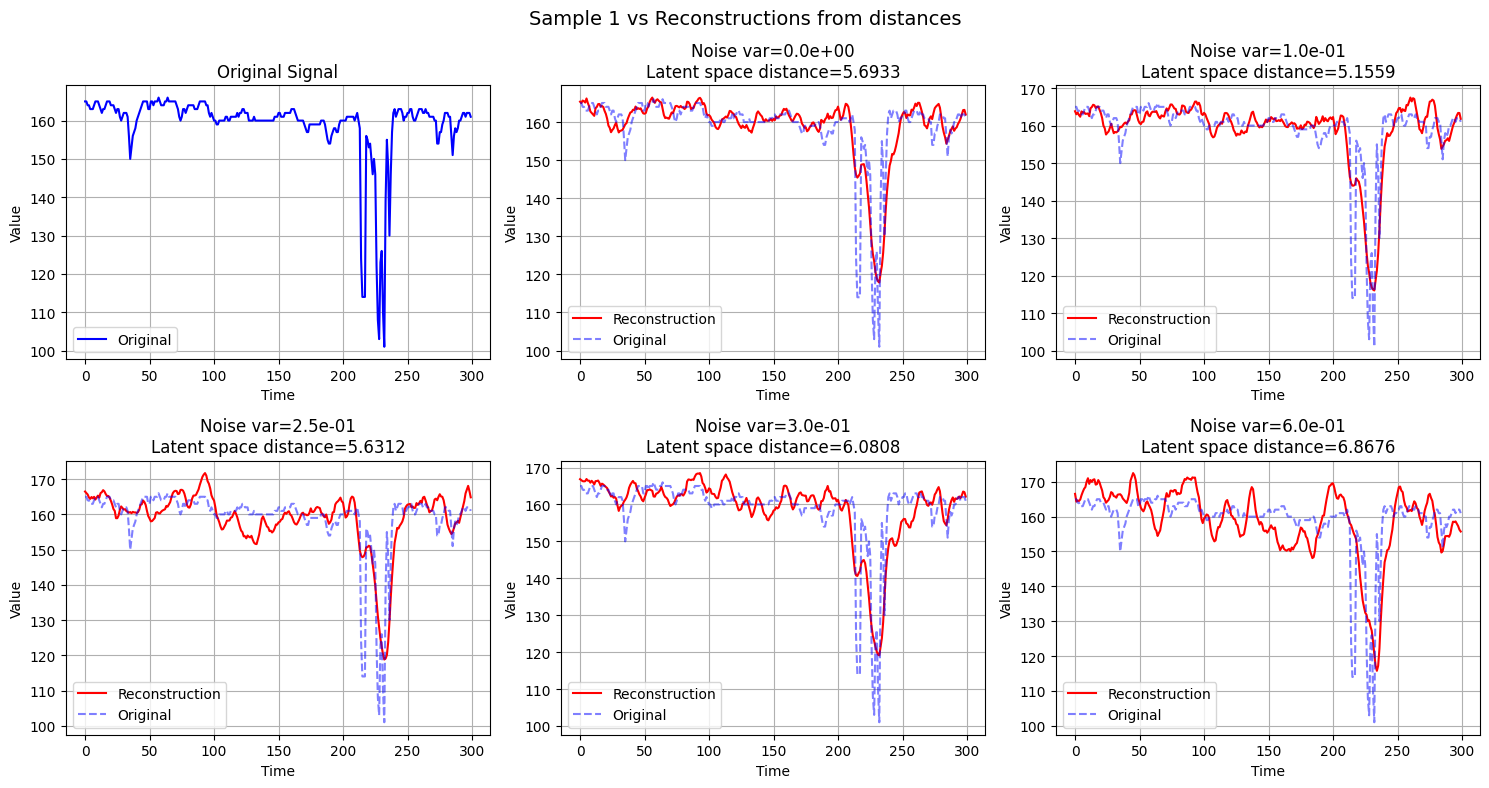

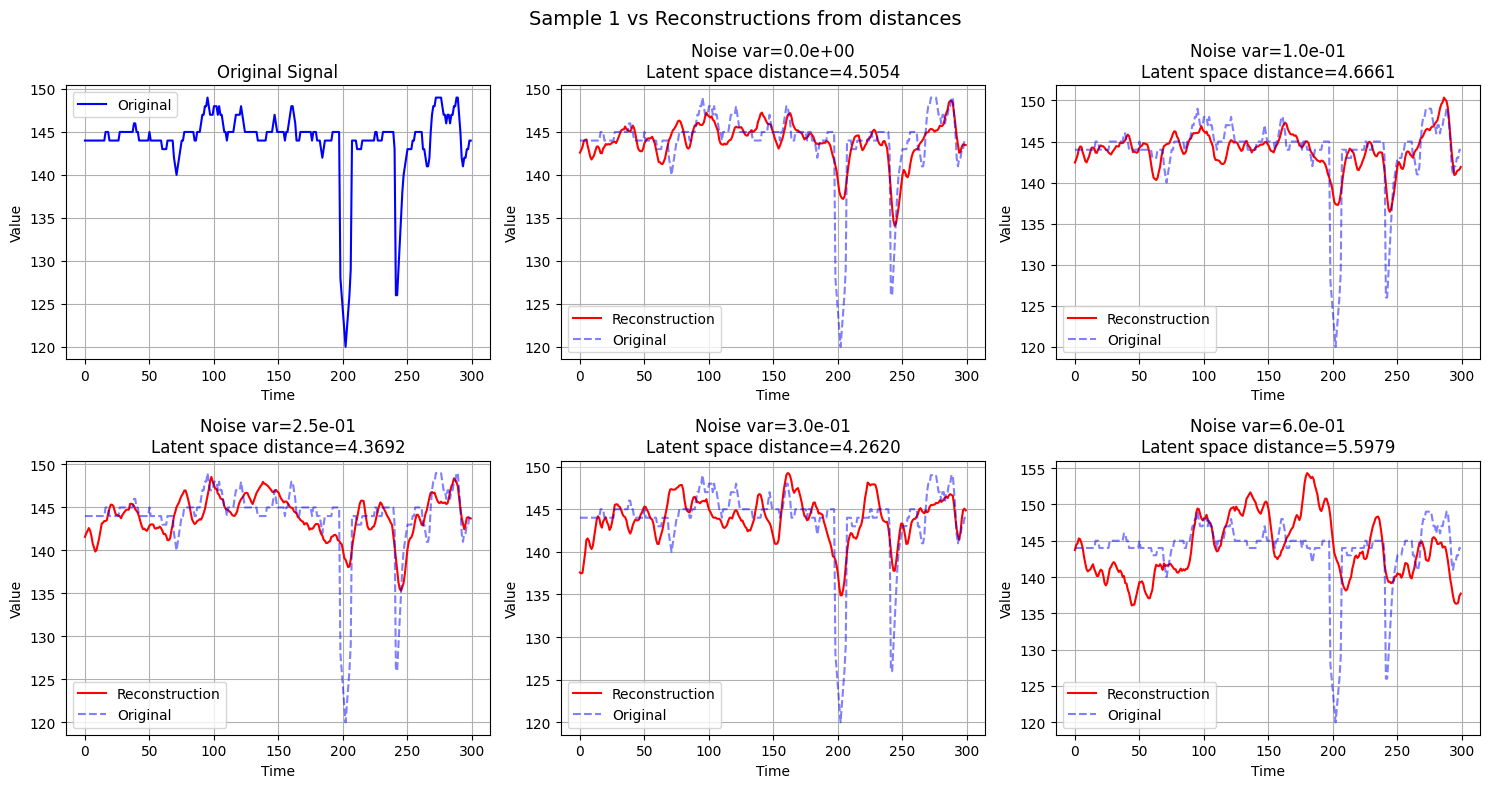

In [8]:
# overwrite = False
from_clip = True
if overwrite:
    if from_clip or not os.path.exists(model_path):
        # load model and eval from checkpoint of clip
        model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
        eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
        eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
        train_losses = eval_dict_ts2txt['train_losses']
        test_losses = eval_dict_ts2txt['test_losses']
    else: 
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        losses = torch.load(output_dir+'/losses.pth', map_location=torch.device(device))
        train_losses = losses['train_losses']
        test_losses = losses['test_losses']
        
    # ------------------------- ready training for vae decoder -------------------------
    # 1. Freeze encoders
    for param in model.ts_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False
    # 2. Unfreeze logvar_layer in ts_encoder to trainable
    for param in model.ts_encoder.logvar_layer.parameters():
        param.requires_grad = False
    # 3. Unfreeze decoder
    for param in model.ts_decoder.parameters():
        param.requires_grad = True
    # Verify parameters
    print("Checking trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}")
    
    # Create optimizer with only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=100,       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-3,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=1000) # for the first 1000 epochs, favor reconstruction more


    
    for i in range(config_dict['num_saves']*5):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs']*10, 
                                                        train_type='joint',
                                                        alpha = 1)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({'train_losses': train_losses,
                    'test_losses': test_losses}, output_dir+'/losses.pth')
    
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    losses = torch.load(output_dir+'/losses.pth', map_location=torch.device(device))
    train_losses = losses['train_losses']
    test_losses = losses['test_losses']
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 3))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    # eval vae
    plot_reconstructions(model, 
                        df=df_train, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Training Data Reconstructions")

    plot_reconstructions(model, 
                        df=df_test, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Test Data Reconstructions")
    distances = [0, 0.1, 0.25, 0.3, 0.6]
    plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'], distances = distances)
    

### Inference

In [9]:
df_train_high = df_train[df_train['text'] == 'High amount of consecutive increases.'].reset_index(drop=True)
df_train_low = df_train[df_train['text'] == 'Low amount of consecutive increases.'].reset_index(drop=True)
df_test_high = df_test[df_test['text'] == 'High amount of consecutive increases.'].reset_index(drop=True)
df_test_low = df_test[df_test['text'] == 'Low amount of consecutive increases.'].reset_index(drop=True)


In [10]:
top = 100
df_high = df_train_high.iloc[range(top)].copy()
df_low = df_train_low.iloc[range(top)].copy()
df = pd.concat([df_low, df_high], ignore_index=True)
df['text1'] = 'low'
df['text2'] = 'high'
text_cols = ['text1', 'text2']

pairwise_distances, ts2tx_distances = cal_embeddings_distances(df, text_cols, model, config_dict)


In [14]:

def plot_embeddings_graph(adj_mat):
    # Create a network graph
    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np
    
    # zero out lower than 50 percentile
    adj_mat[adj_mat < np.percentile(adj_mat, 50)] = 0
    np.fill_diagonal(adj_mat, 0)  # Remove self-loops

    # Create and draw network
    G = nx.from_numpy_array(adj_mat)
    pos = nx.spring_layout(G, k=0.5, iterations=5000)

    plt.figure(figsize=(6, 4))

    # Create color list with three groups
    n_nodes = len(G.nodes())
    n_remaining = n_nodes - 2
    half_remaining = n_remaining // 2

    # Draw edges first
    nx.draw_networkx_edges(G, pos,
                          edge_color='grey',
                          width=0.1)

    # Draw first two nodes as triangles
    first_two_nodes = list(G.nodes())[:2]
    first_two_colors = ['darkgreen', 'blue']
    nx.draw_networkx_nodes(G, pos,
                          nodelist=first_two_nodes,
                          node_color=first_two_colors,
                          node_shape='^',
                          node_size=100)

    # Draw remaining nodes as circles, split into two color groups
    remaining_nodes_first_half = list(G.nodes())[2:2+half_remaining]
    remaining_nodes_second_half = list(G.nodes())[2+half_remaining:]
    
    nx.draw_networkx_nodes(G, pos,
                          nodelist=remaining_nodes_first_half,
                          node_color='darkgreen',
                          node_size=10)
    
    nx.draw_networkx_nodes(G, pos,
                          nodelist=remaining_nodes_second_half,
                          node_color='blue',
                          node_size=10)
    
    # Add node indices as labels
    labels = {i: str(i) for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=3)
    
    plt.show()



In [15]:
top = 100
df_high = df_train_high.iloc[range(top)].copy()
df_low = df_train_low.iloc[range(top)].copy()
df = pd.concat([df_low, df_high], ignore_index=True)
df['text1'] = 'low'
df['text2'] = 'high'
text_cols = ['text1', 'text2']

pairwise_distances, ts2tx_distances = cal_embeddings_distances(df, text_cols, model, config_dict)


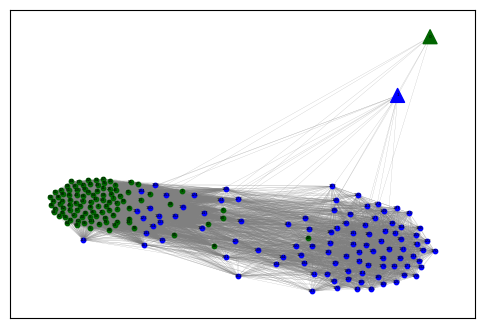

In [16]:

adj_mat = pairwise_distances['simi'].detach().cpu().numpy()
# adj_mat = pairwise_distances['l2'].detach().cpu().numpy()
# adj_mat = pairwise_distances['l1'].detach().cpu().numpy()
# adj_mat = 1/(adj_mat+1e-8)

plot_embeddings_graph(adj_mat)



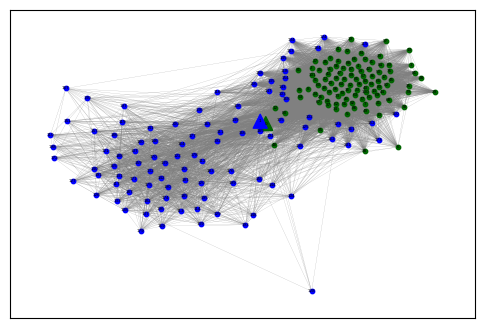

In [17]:
adj_mat = pairwise_distances['l2'].detach().cpu().numpy()
# adj_mat = pairwise_distances['l1'].detach().cpu().numpy()
adj_mat = 1/(adj_mat+1e-8)

plot_embeddings_graph(adj_mat)

In [26]:

for i in range(95, 105):
    print(ts2tx_distances['simi']['low'][i])
    print(ts2tx_distances['simi']['high'][i])


tensor(1.5042, grad_fn=<SelectBackward0>)
tensor(1.2972, grad_fn=<SelectBackward0>)
tensor(0.5807, grad_fn=<SelectBackward0>)
tensor(0.1192, grad_fn=<SelectBackward0>)
tensor(0.7137, grad_fn=<SelectBackward0>)
tensor(0.1099, grad_fn=<SelectBackward0>)
tensor(0.5706, grad_fn=<SelectBackward0>)
tensor(0.0693, grad_fn=<SelectBackward0>)
tensor(0.6992, grad_fn=<SelectBackward0>)
tensor(0.3103, grad_fn=<SelectBackward0>)
tensor(1.1726, grad_fn=<SelectBackward0>)
tensor(4.1844, grad_fn=<SelectBackward0>)
tensor(5.8627, grad_fn=<SelectBackward0>)
tensor(6.1804, grad_fn=<SelectBackward0>)
tensor(1.3655, grad_fn=<SelectBackward0>)
tensor(2.7297, grad_fn=<SelectBackward0>)
tensor(0.5788, grad_fn=<SelectBackward0>)
tensor(0.9292, grad_fn=<SelectBackward0>)
tensor(12.7710, grad_fn=<SelectBackward0>)
tensor(38.8594, grad_fn=<SelectBackward0>)


In [27]:

for i in range(95, 105):
    print(ts2tx_distances['l2']['low'][i])
    print(ts2tx_distances['l2']['high'][i])


tensor(9.4526, grad_fn=<SelectBackward0>)
tensor(9.4419, grad_fn=<SelectBackward0>)
tensor(7.5873, grad_fn=<SelectBackward0>)
tensor(7.7611, grad_fn=<SelectBackward0>)
tensor(7.6179, grad_fn=<SelectBackward0>)
tensor(7.8279, grad_fn=<SelectBackward0>)
tensor(7.6442, grad_fn=<SelectBackward0>)
tensor(7.8836, grad_fn=<SelectBackward0>)
tensor(7.7426, grad_fn=<SelectBackward0>)
tensor(7.8150, grad_fn=<SelectBackward0>)
tensor(8.5332, grad_fn=<SelectBackward0>)
tensor(8.3530, grad_fn=<SelectBackward0>)
tensor(8.2871, grad_fn=<SelectBackward0>)
tensor(8.2506, grad_fn=<SelectBackward0>)
tensor(9.5015, grad_fn=<SelectBackward0>)
tensor(9.4019, grad_fn=<SelectBackward0>)
tensor(8.5363, grad_fn=<SelectBackward0>)
tensor(8.4512, grad_fn=<SelectBackward0>)
tensor(8.4616, grad_fn=<SelectBackward0>)
tensor(8.2991, grad_fn=<SelectBackward0>)


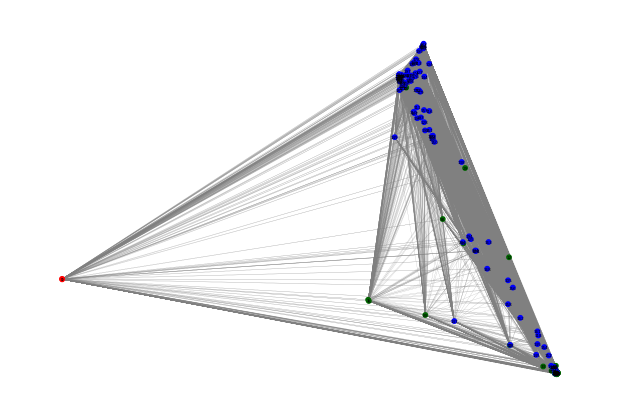

In [29]:

adj_mat = pairwise_distances['simi'].detach().cpu().numpy()
# adj_mat = pairwise_distances['l2'].detach().cpu().numpy()
# adj_mat = pairwise_distances['l1'].detach().cpu().numpy()
# adj_mat = 1/(adj_mat+1e-8)

plot_embeddings_graph(adj_mat)



In [26]:
df_infer = df_train_high.copy()
df = df_infer.iloc[[tid]].copy()
df['text1'] = 'Low amount of consecutive increases.'
df['text2'] = 'High amount of consecutive increases.'
text_cols = ['text1', 'text2']

tx_emb1 = model.text_encoder(tx_f_ls[0])
tx_emb2 = model.text_encoder(tx_f_ls[1])
# get the euclidean distance between ts_emb and tx_emb
print(f'L1 norm distance: {torch.norm(tx_emb1 - tx_emb2, dim=1, p=1)}')
print(f'L2 norm distance: {torch.norm(tx_emb1 - tx_emb2, dim=1, p=2)}')
print(f'dot product similarity: {torch.exp(torch.matmul(tx_emb1, tx_emb2.T)[0])}')

l2 norm distance: tensor([20.6650], grad_fn=<LinalgVectorNormBackward0>)
dot product similarity: tensor([148733.8906], grad_fn=<ExpBackward0>)


0    Low amount of consecutive increases.
Name: text, dtype: object
30


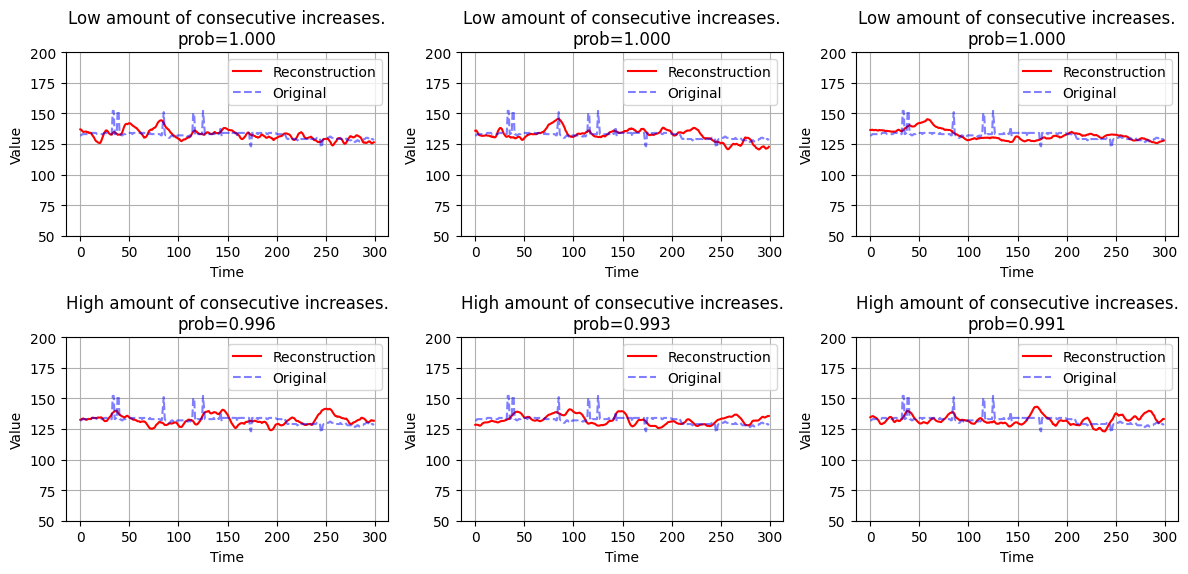

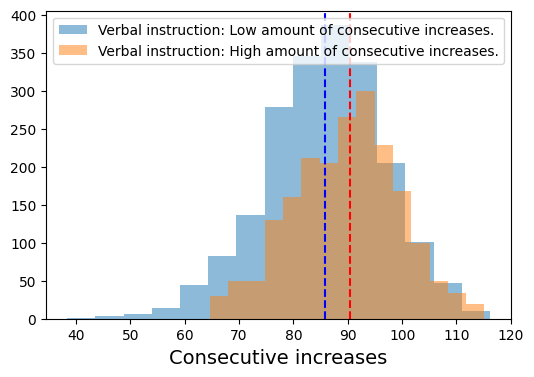

1    Low amount of consecutive increases.
Name: text, dtype: object
12


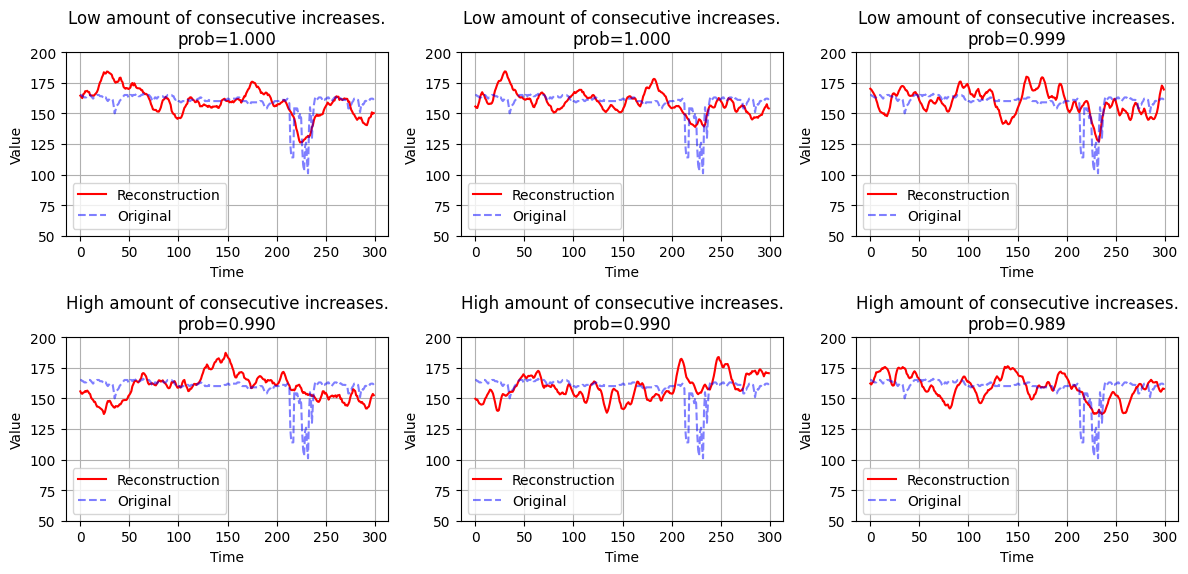

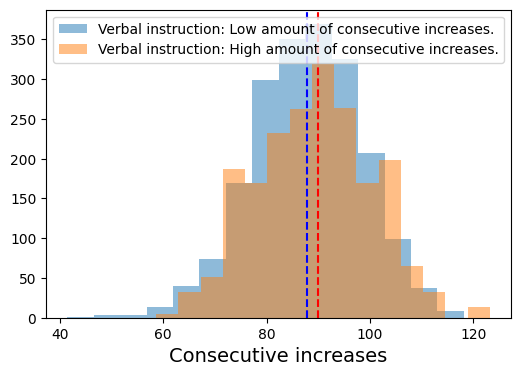

2    Low amount of consecutive increases.
Name: text, dtype: object
44


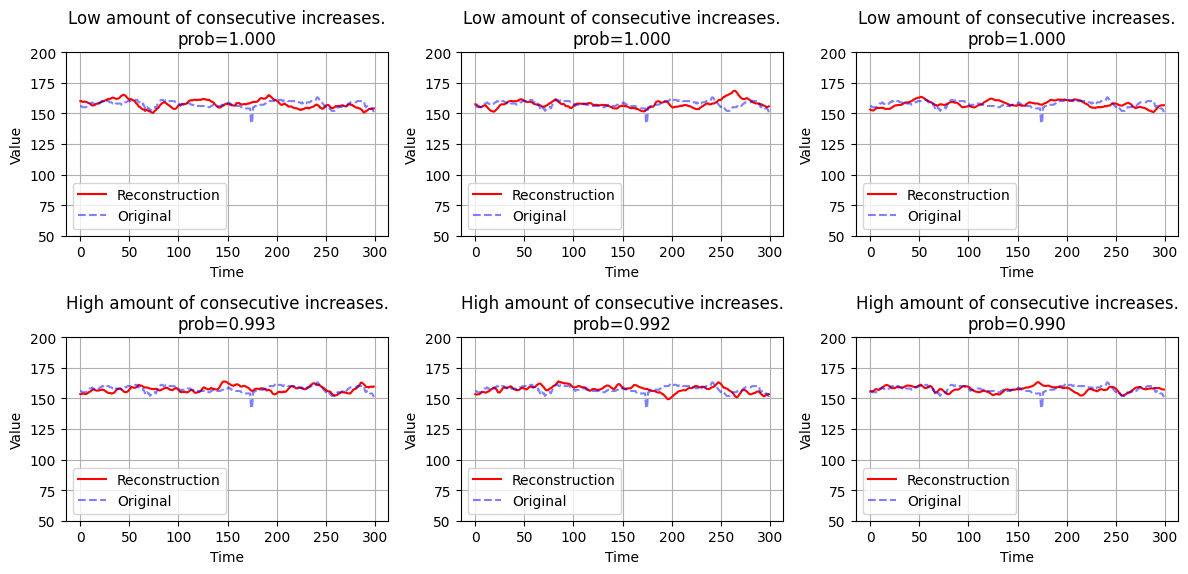

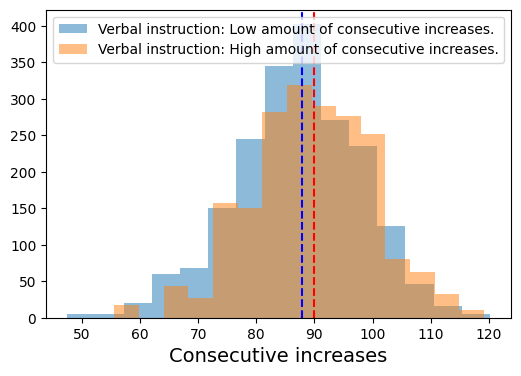

3    Low amount of consecutive increases.
Name: text, dtype: object
36


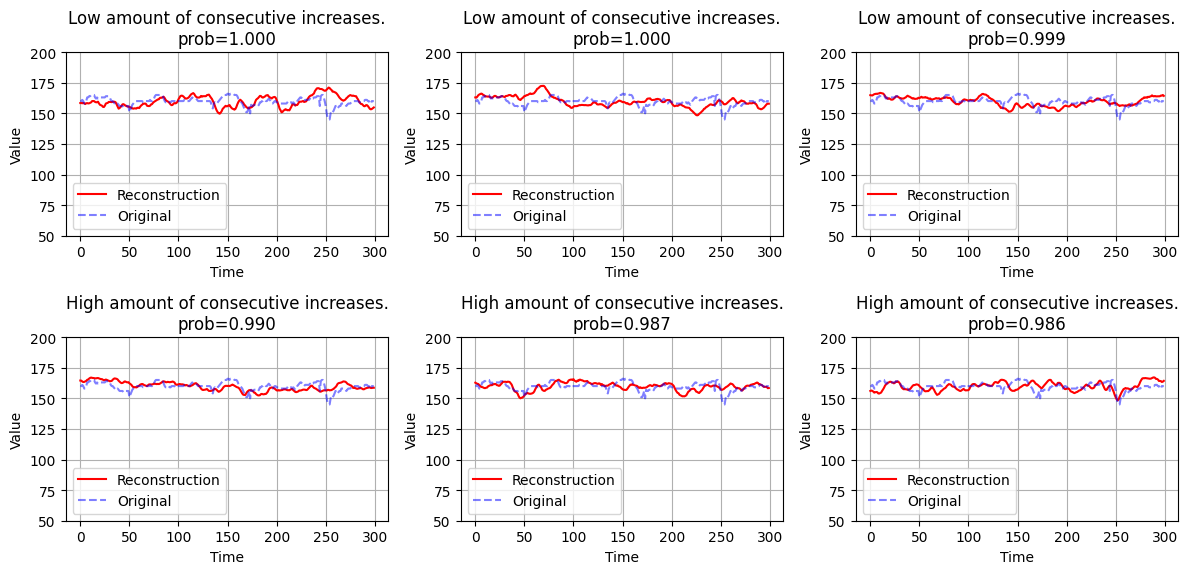

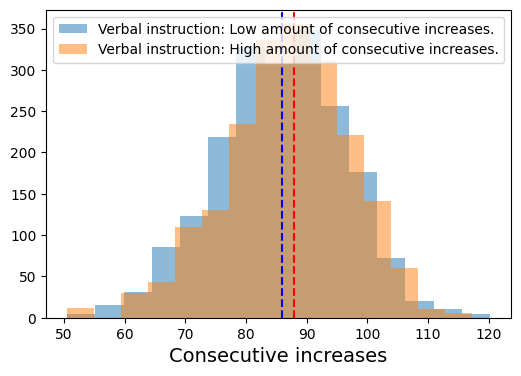

4    Low amount of consecutive increases.
Name: text, dtype: object
16


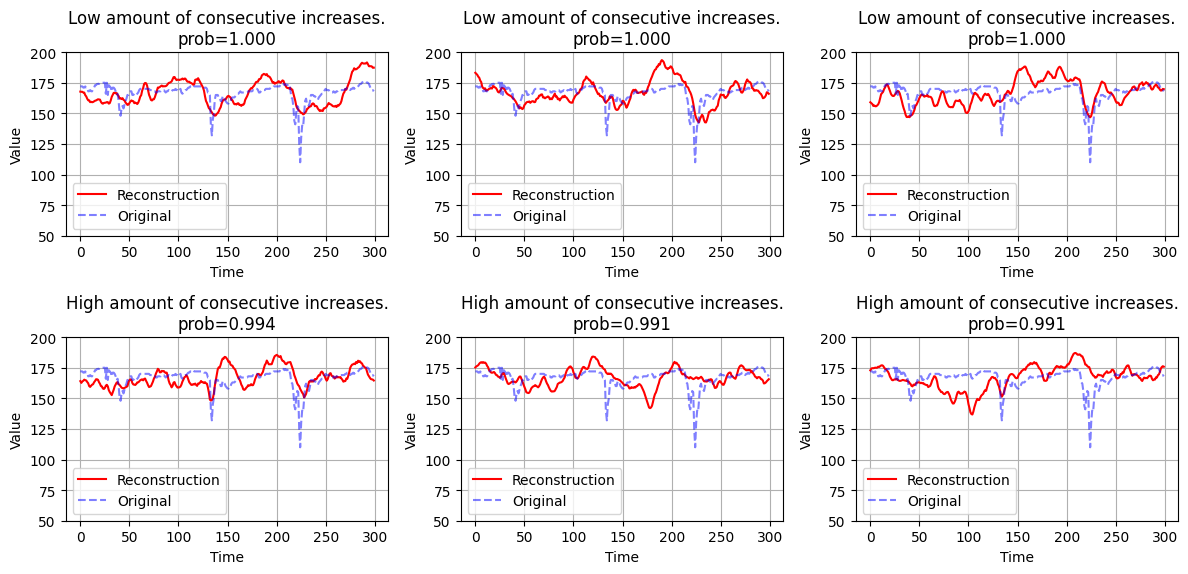

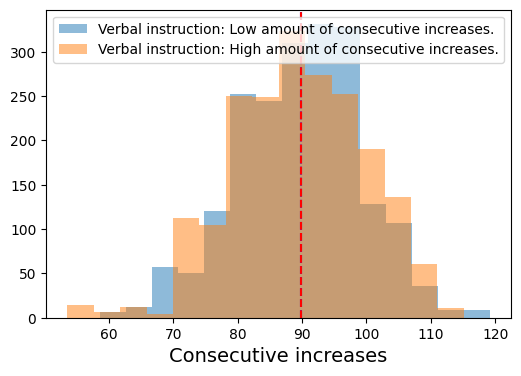

5    Low amount of consecutive increases.
Name: text, dtype: object
36


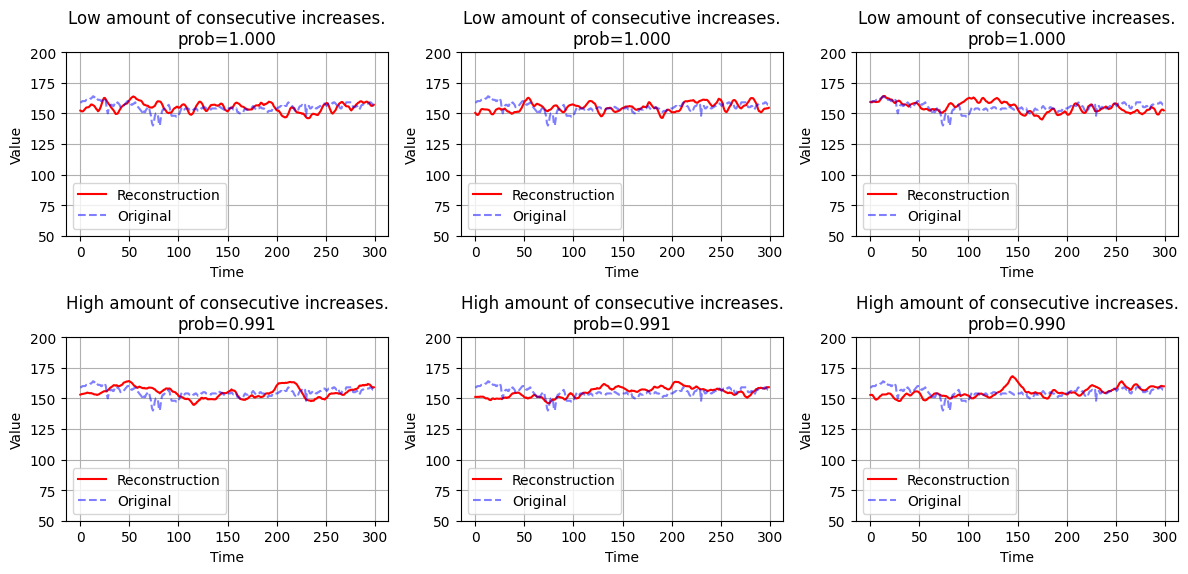

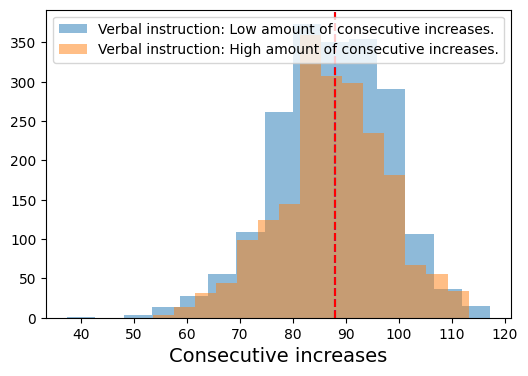

6    Low amount of consecutive increases.
Name: text, dtype: object
38


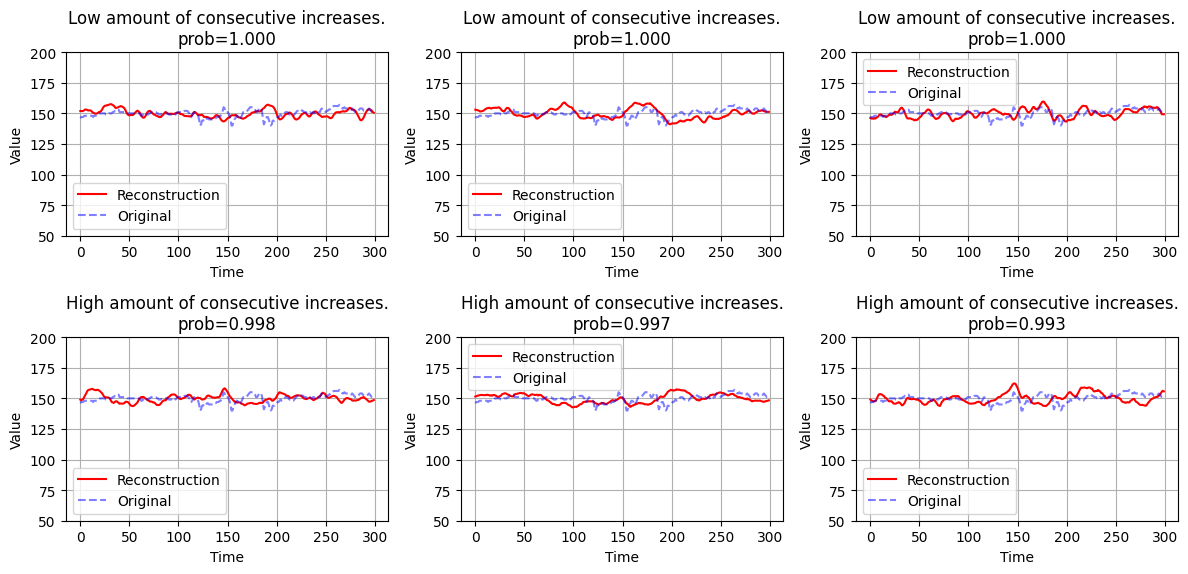

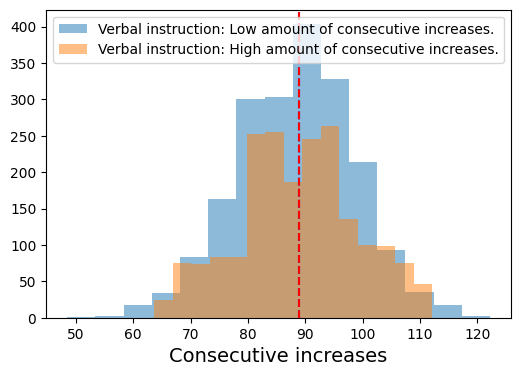

7    Low amount of consecutive increases.
Name: text, dtype: object
32


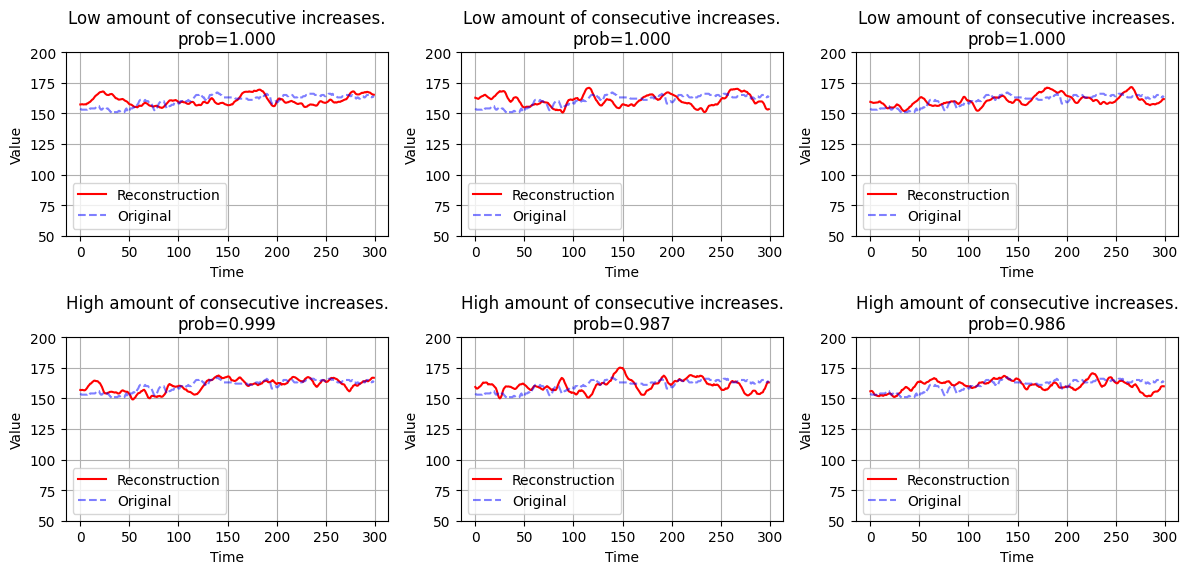

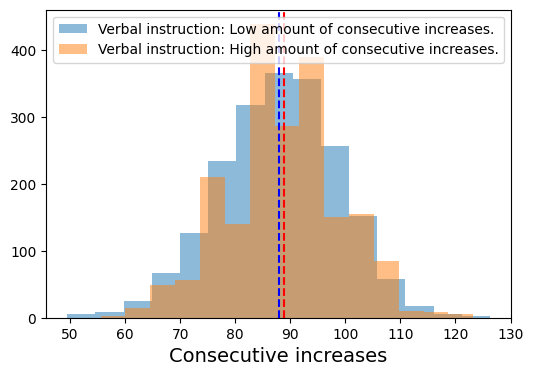

8    Low amount of consecutive increases.
Name: text, dtype: object
42


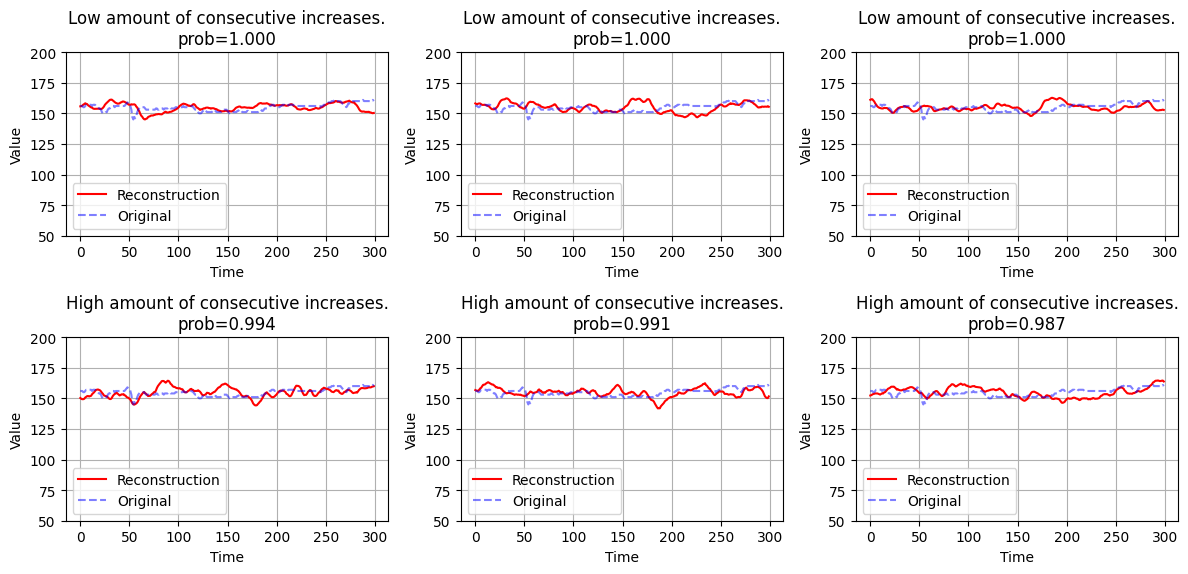

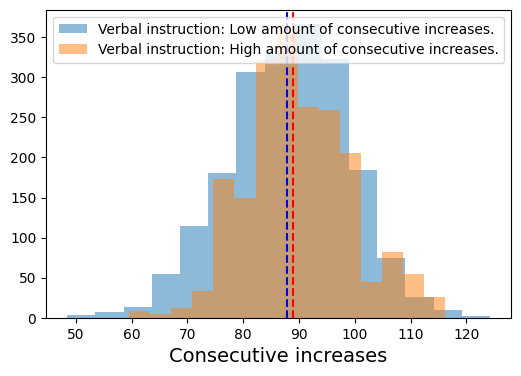

9    Low amount of consecutive increases.
Name: text, dtype: object
38


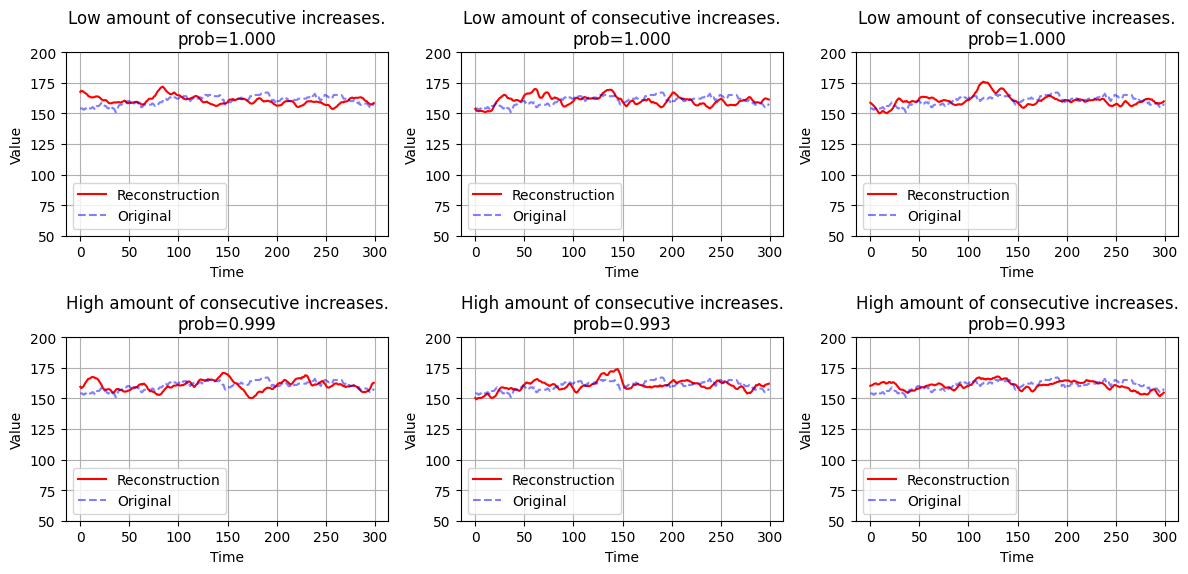

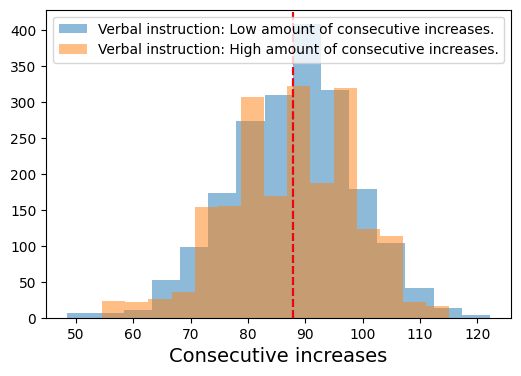

In [98]:
for tid in range(10):

    df_infer = df_train_low.copy()
    df = df_infer.iloc[[tid]].copy()
    print(df['text'])

    df['text1'] = 'Low amount of consecutive increases.'
    df['text2'] = 'High amount of consecutive increases.'


    min_total_hats_lower = 500 # minimum total number of reconstructions per text
    highprob_hats_ratio = 0.1 # at least this ratio of reconstructions should have probability > 0.9

    for vr in range(0, 50, 2):
        cts_hat, c_probs = vital1_contrast_infer(df, model, config_dict, text_cols = ['text1','text2'], var_ratio = vr, K = 5000)
        min_total_hats = min([len(v) for v in cts_hat.values()])
        min_highprob_hats = min([sum(probs > 0.9) for probs in c_probs.values()])
        if min_total_hats > min_total_hats_lower and min_highprob_hats/min_total_hats > highprob_hats_ratio:
            print(vr)
            break
    
    ts = df.loc[:,'1':'300'].values[0]
    plot_vital_contrast_reconstructions(ts, cts_hat, c_probs)





    boot = 2000
    th = 0.75
    res = {}
    plt.figure(figsize=(6, 4))
    for txid, (text_condition, ts_hats) in enumerate(cts_hat.items()):
        probs = c_probs[text_condition]
        ts_hats = ts_hats[probs > th]
        probs = probs[probs > th]
        
        replace = ts_hats.shape[0] < boot
        idx = np.random.choice(ts_hats.shape[0], boot, replace=replace)
        ts_hats = ts_hats[idx]
        probs = probs[idx]
        probs = probs/sum(probs) # norm
        
        ui = []
        colors = ['blue', 'red']
        for j in range(len(ts_hats)):
            o = successive_increases(ts_hats[j].detach().cpu().numpy())
            p = probs[j].detach().cpu().numpy()
            u = round(o['uuu']*3*100, 2)#  + o['u']
            wu = p*u
            ui.append(u)
        res[text_condition] = ui
        plt.hist(ui, bins=15, alpha=0.5, label=f"Verbal instruction: {text_condition}")
        # add mean and median
        # plt.axvline(x=np.mean(ui), color='blue', linestyle='--')
        plt.axvline(x=np.median(ui), color=colors[txid], linestyle='--')
    plt.xlabel('Consecutive increases',fontsize=14)
    plt.legend(fontsize=10)
    plt.show()

In [ ]:
# i = 3
# distance_ratios = [1]
# threshold = 0
# K = 10000 # at each given distance ratio, sample K Zs
# top = 1000
# keep = 3
# poptop = False
# df_infer = df_train.copy()
# df = df_infer.iloc[[i]].copy()
# print(df['text'].to_list()[0])

# df = df_infer.iloc[[i]].copy()
# ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
#                                                               text_col = 'text',
#                                                               # text_col_ls=['cl_event', 'ts_description', 'demo'],
#                                                               distance_ratios = distance_ratios,
#                                                              threshold = threshold,
#                                                               poptop = poptop)
# plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text'].tolist()[0],
#                                                              keep = keep)

# df = df_infer.iloc[[i]].copy()
# df['text1'] = 'High amount of consecutive increases.'

# ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
#                                                               text_col = 'text1',
#                                                               # text_col_ls=['cl_event', 'text1', 'demo'],
#                                                              distance_ratios = distance_ratios,
#                                                              threshold = threshold,
#                                                               poptop = poptop)
# plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0],
#                                                              keep = keep)

# df = df_infer.iloc[[i]].copy()
# df['text1'] = 'Low amount of consecutive increases.'

# ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
#                                                               text_col = 'text1',
#                                                               # text_col_ls=['cl_event', 'text1', 'demo'],
#                                                              distance_ratios = distance_ratios,
#                                                              threshold = threshold,
#                                                               poptop = poptop)
# plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0],
#                                                              keep = keep)


In [ ]:
# i = 3
# distance_ratios = [50, 100, 200]
# threshold = 0
# K = 100 # at each given distance ratio, sample K Zs
# top = 5
# df_infer = df_train.copy()
# df = df_infer.iloc[[i]].copy()
# print(df['text'].to_list()[0])

In [ ]:
# u0 = []
# u1 = []
# u2 = []

# for _ in range(20):

#     df = df_infer.iloc[[i]].copy()
#     ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
#                                                                 text_col = 'text',
#                                                                 # text_col_ls=['cl_event', 'ts_description', 'demo'],
#                                                                 K = K,
#                                                                 top = top,
#                                                                 distance_ratios = distance_ratios,
#                                                                 threshold = threshold)

#     for i in range(len(top_ts_hats)):
#         o = successive_increases(top_ts_hats[i].detach().cpu().numpy())
#         p = round(top_probs[i].detach().cpu().numpy()*100, 2)
#         u = round(o['uuu']*3 + o['uu']*2, 2)#  + o['u']
#         wu = u*p
#         u0.append(u)


#     df['text1'] = 'High amount of consecutive increases.'
#     ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
#                                                                 text_col = 'text1',
#                                                                 # text_col_ls=['cl_event', 'ts_description', 'demo'],
#                                                                 K = K,
#                                                                 top = top,
#                                                                 distance_ratios = distance_ratios,
#                                                                 threshold = threshold)

#     for i in range(len(top_ts_hats)):
#         o = successive_increases(top_ts_hats[i].detach().cpu().numpy())
#         p = round(top_probs[i].detach().cpu().numpy()*100, 2)
#         u = round(o['uuu']*3 + o['uu']*2 , 2) # + o['u']
#         wu = u*p
#         u1.append(u)


#     df['text2'] = 'Low amount of consecutive increases.'
#     ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
#                                                                 text_col = 'text2',
#                                                                 # text_col_ls=['cl_event', 'ts_description', 'demo'],
#                                                                 K = K,
#                                                                 top = top,
#                                                                 distance_ratios = distance_ratios,
#                                                                 threshold = threshold)

#     for i in range(len(top_ts_hats)):
#         o = successive_increases(top_ts_hats[i].detach().cpu().numpy())
#         p = round(top_probs[i].detach().cpu().numpy()*100, 2)
#         u = round(o['uuu']*3 + o['uu']*2 , 2)# + o['u']
#         wu = u*p
#         u2.append(u)


In [ ]:
# import numpy as np

# # Assuming u0, u1, u2 are lists
# u0 = np.array(u0)
# u1 = np.array(u1)
# u2 = np.array(u2)

# # Now you can perform the operation
# # u0[u0 > 20] = 20
# # u1[u1 > 20] = 20
# # u2[u2 > 20] = 20
# # plot the histogram of u0, u1, u2
# plt.hist(u0, bins=20, alpha=0.5, label=df['text'].tolist()[0]) # low (raw)
# plt.hist(u1, bins=20, alpha=0.5, label=df['text1'].tolist()[0]) # higher
# plt.hist(u2, bins=20, alpha=0.5, label=df['text2'].tolist()[0]) # lower
# plt.legend()
# plt.show()


In [ ]:
# ts_f = None
# tx_f = None
# tx_f_ls = None

# if config_dict['3d']:

#     for _, (_, ts, text_features, _, _) in enumerate(train_dataloader):
#         if ts_f is None:
#             ts_f  = ts
#         else: 
#             ts_f = torch.cat([ts_f, ts], dim=0)
#         if tx_f_ls is None:
#             tx_f_ls = text_features
#         else: 
#             tx_f_ls = [torch.cat([tx_f_ls[i], text_features[i]], dim=0) for i in range(len(tx_f_ls))]
# else:

#     for _, (_, ts, text_features, _, _) in enumerate(train_dataloader):
#         if ts_f is None:
#             ts_f  = ts
#         else: 
#             ts_f = torch.cat([ts_f, ts], dim=0)
#         if tx_f is None:
#             tx_f = text_features
#         else: 
#             tx_f = torch.cat([tx_f, text_features], dim=0)



In [ ]:
# # get z_means for ts_f
# _, z_mean, _, _, _ = model.ts_encoder(ts_f)
# # get c for tx_f_ls or tx_f
# c = model.text_encoder(tx_f)

# # z_means is dim (N, embed_dim) get dot product similarity between z_means using clip
# dps_zc = model.clip(z_mean, c)

# # take exp of dps_zc, dps_zz, dps_cc
# dps_zc = torch.exp(dps_zc)
# del z_mean, c
# torch.cuda.empty_cache()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Convert to numpy if not already
# if torch.is_tensor(dps_zc):
#     dps_zc = dps_zc.cpu().detach().numpy()

# # Get upper triangle values (excluding diagonal)
# upper_triangle = dps_zc[np.triu_indices_from(dps_zc, k=1)]

# # Plot histogram
# plt.figure(figsize=(10, 6))
# plt.hist(upper_triangle, bins=50, density=True, alpha=0.7)
# plt.title('Distribution of Similarity Scores')
# plt.xlabel('Similarity Score')
# plt.ylabel('Density')

# # Add summary statistics
# print(f"Summary Statistics:")
# print(f"Mean: {upper_triangle.mean():.3f}")
# print(f"Median: {np.median(upper_triangle):.3f}")
# print(f"Std: {upper_triangle.std():.3f}")
# print(f"Min: {upper_triangle.min():.3f}")
# print(f"Max: {upper_triangle.max():.3f}")

# # Optional: Add vertical lines for potential thresholds
# percentiles = [25, 50, 75]
# for p in percentiles:
#     threshold = np.percentile(upper_triangle, p)
#     plt.axvline(x=threshold, color='r', linestyle='--', alpha=0.3)
#     plt.text(threshold, plt.ylim()[1], f'{p}th', rotation=0)

# plt.grid(True, alpha=0.3)
# plt.show()


In [ ]:
# import pandas as pd
# import numpy as np

# def prepare_for_gephi(dps, threshold=0, output_prefix="network"):
#     """
#     Convert similarity matrix to Gephi-compatible CSV files
#     Creates two files:
#     - nodes.csv: node list with IDs
#     - edges.csv: edge list with weights
#     """
#     # Convert to numpy if tensor
#     if torch.is_tensor(dps_zc):
#         adj_matrix = dps_zc.cpu().detach().numpy()
#     else:
#         adj_matrix = dps_zc
    
#     # Create nodes dataframe
#     nodes_df = pd.DataFrame({
#         'Id': range(len(adj_matrix)),
#         'Label': range(len(adj_matrix))
#     })
    
#     # Create edges dataframe
#     edges = []
#     for i in range(len(adj_matrix)):
#         for j in range(i+1, len(adj_matrix)):  # upper triangle only
#             weight = adj_matrix[i,j]
#             if weight > threshold:
#                 edges.append({
#                     'Source': i,
#                     'Target': j,
#                     'Weight': weight,
#                     'Type': 'Undirected'
#                 })
    
#     edges_df = pd.DataFrame(edges)
    
#     # Save to CSV
#     nodes_df.to_csv(f"{output_dir}/{output_prefix}_nodes.csv", index=False)
#     edges_df.to_csv(f"{output_dir}/{output_prefix}_edges.csv", index=False)
    
#     print(f"Created {len(nodes_df)} nodes and {len(edges_df)} edges")
#     print(f"Files saved as {output_prefix}_nodes.csv and {output_prefix}_edges.csv")
    
#     return nodes_df, edges_df

# thresh = 20
# nodes, edges = prepare_for_gephi(dps_zc, 
#                                threshold=thresh,
#                                output_prefix=f"network_thresh_{thresh}")



In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_similarity_network(adj_matrix, threshold=0.5, max_nodes=100, node_size=100, figsize=(12, 12)):
#     """
#     Plot network from similarity matrix with weighted edges
    
#     Args:
#         adj_matrix: torch.Tensor, similarity matrix (N x N)
#         threshold: float, minimum similarity to draw edge
#         max_nodes: int, maximum number of nodes to plot
#         node_size: int, size of nodes in visualization
#         figsize: tuple, figure size
#     """
#     # Convert to numpy if tensor
#     if torch.is_tensor(adj_matrix):
#         adj_matrix = adj_matrix.cpu().detach().numpy()
#     else:
#         adj_matrix = adj_matrix

#     # If matrix is too large, take first max_nodes
#     if adj_matrix.shape[0] > max_nodes:
#         adj_matrix = adj_matrix[:max_nodes, :max_nodes]
    
#     # Create graph
#     G = nx.Graph()
    
#     # Add edges with weights above threshold
#     n = adj_matrix.shape[0]
#     for i in range(n):
#         for j in range(i+1, n):  # Upper triangle only (undirected graph)
#             if adj_matrix[i,j] > threshold:
#                 G.add_edge(i, j, weight=adj_matrix[i,j])
    
#     # Get position layout
#     pos = nx.spring_layout(G, k=1/np.sqrt(n), iterations=50)
    
#     # Plot
#     plt.figure(figsize=figsize)
    
#     # Draw nodes
#     nx.draw_networkx_nodes(G, pos, 
#                           node_color='lightblue',
#                           node_size=node_size)
    
#     # Draw edges with width proportional to weight
#     edges = G.edges()
#     weights = [G[u][v]['weight'] for u,v in edges]
    
#     # Normalize edge widths
#     max_width = 5
#     min_width = 0.1
#     if weights:  # Check if there are any edges
#         normalized_weights = [(w-min(weights))/(max(weights)-min(weights))*(max_width-min_width)+min_width 
#                             for w in weights]
#     else:
#         normalized_weights = []
    
#     nx.draw_networkx_edges(G, pos, 
#                           width=normalized_weights,
#                           alpha=0.5,
#                           edge_color='gray')
    
#     # Add labels
#     nx.draw_networkx_labels(G, pos, 
#                            font_size=8)
    
#     plt.title(f'Similarity Network (threshold={threshold})\nNodes: {n}, Edges: {len(edges)}')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
#     return G
